<a href="https://colab.research.google.com/github/leedain0301/Data_MiniProject_02/blob/main/MiniProject_02_%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 컬럼 설명

#   train.csv / test.csv <br>
>  : 서울 지역의 740,000여개 거래 데이터, 아파트 거래일, 지역, 전용면적, 실 거래가 등의 정보

- **features**
  *   transaction_id : 아파트 거래 유일키키
  *   apartment_id : 아파트 아이디
  *   city : 도시
  *   dong : 동
  *   jibun : 지번
  *   apt : 아파트단지 이름
  *   addr_kr : 주소
  *   exclusive_use_area : 전용면적
  *   year_of_completion : 설립일자
  *   transaction_year_month : 거래년월
  *   transaction_date : 거래날짜
  *   floor : 층
  *   transaction_real_price : 실거래가(train 만 존재)



<br>

---

<br>









In [109]:
!pip install category_encoders


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import sklearn
from sklearn.linear_model    import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.ensemble        import GradientBoostingRegressor, RandomForestRegressor
from sklearn.kernel_ridge    import KernelRidge
from sklearn.pipeline        import make_pipeline
from sklearn.preprocessing   import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics         import mean_squared_error, accuracy_score
from sklearn.preprocessing   import StandardScaler
from sklearn.impute          import SimpleImputer
from category_encoders       import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble        import RandomForestClassifier
from sklearn.tree            import DecisionTreeRegressor

import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
import sys

In [122]:
train = pd.read_csv('/content/drive/MyDrive/02.Colab Notebooks/MiniProject_02/train_clean2.csv')
test = pd.read_csv('/content/drive/MyDrive/02.Colab Notebooks/MiniProject_02/test_clean2.csv')
submission_data = pd.read_csv('/content/drive/MyDrive/02.Colab Notebooks/MiniProject_02/submission.csv')

print('train.csv. Shape: ',train.shape)
print('test.csv. Shape: ', test.shape)

train.csv. Shape:  (742285, 8)
test.csv. Shape:  (3911, 7)


In [123]:
# train = train.drop('Unnamed: 0', axis=1)
# test = test.drop('Unnamed: 0', axis=1)
# train['transaction_real_price'] = np.expm1(train['transaction_real_price'])
train.head()

,dong,exclusive_use_area,year_of_completion,transaction_date,floor,transaction_real_price,year,month
0,0.273716,0.402730,0.438402,1,-1.412283,-0.344563,-1.800144,-1.609647
1,1.052800,0.821636,-2.785336,2,-0.333916,-0.861271,-1.800144,-1.609647
2,1.052800,0.400204,0.994219,2,-0.333916,-0.315037,-1.800144,-1.609647
3,1.615473,1.868010,0.549565,3,1.092432,2.032290,-1.800144,-1.609647
4,1.615473,2.632362,0.660729,1,-1.093698,2.091343,-1.800144,-1.609647


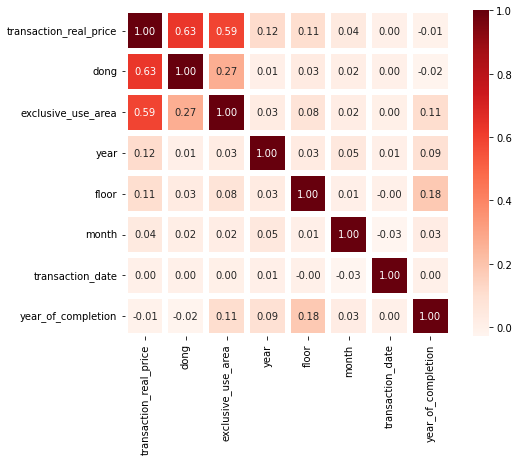

In [124]:
k=train.shape[1]
corrmat=train.corr()
cols=corrmat.nlargest(k,'transaction_real_price')['transaction_real_price'].index
cm=np.corrcoef(train[cols].values.T)
f,ax=plt.subplots(figsize=(8,6))
sns.heatmap(data=cm,annot=True,square=True,fmt='.2f',linewidths=5,cmap='Reds',yticklabels=cols.values,xticklabels=cols.values)


In [126]:
baseline_score = train['transaction_real_price'].value_counts(normalize=True).max()
print("baseline score:", baseline_score)

baseline score: 0.011071219275615161


### **< 데이터셋 >**

---


In [127]:
train, val = train_test_split(
    train, train_size=0.80,  random_state=42
)

train.shape, val.shape, test.shape

((593828, 8), (148457, 8), (3911, 7))

In [129]:
target = 'transaction_real_price'
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

### RMSE

---


In [173]:
scores = []
def print_rmse_score(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    scores.append(rmse)
    print('RMSE : ', rmse)
    return rmse

In [174]:
reg = LinearRegression(n_jobs=-1)
ridge = Ridge(alpha=0.8, random_state=1)
lasso = Lasso(alpha = 0.01, random_state=1)
DTree = DecisionTreeRegressor(max_depth=6, min_samples_split=10, min_samples_leaf=15, random_state=1)
rf = RandomForestRegressor(n_estimators=10, criterion='mse', max_depth=9, min_samples_split=50,
                           min_samples_leaf=5, random_state=1, n_jobs=-1)
model_xgb = xgb.XGBRegressor(n_estimators=10, max_depth=9, min_child_weight=5, gamma=0.1, n_jobs=-1)

In [175]:
models = [{'model': reg, 'name':'LinearRegression'}, {'model': ridge, 'name':'Ridge'},
          {'model': lasso, 'name':'Lasso'}, {'model' : DTree, 'name' : 'DecisionTreeRegressor'}, 
          {'model' : rf, 'name' : 'RandomForestRegressor'}, {'model' : model_xgb, 'name' : 'XGBRegressor'}]

In [176]:
clf = reg.fit(X_train, y_train)
pred = clf.predict(X_val)
rmse = print_rmse_score(y_val, pred) 

RMSE :  0.6424956924965175


In [177]:
clf = ridge.fit(X_train, y_train)
pred = clf.predict(X_val)
rmse = print_rmse_score(y_val, pred) 

RMSE :  0.6424953727036109


In [178]:
clf = lasso.fit(X_train, y_train)
pred = clf.predict(X_val)
rmse = print_rmse_score(y_val, pred) 

RMSE :  0.6383542893112842


In [179]:
clf = DTree.fit(X_train, y_train)
pred = clf.predict(X_val)
rmse = print_rmse_score(y_val, pred) 

RMSE :  0.5162402655070207


In [180]:
clf = rf.fit(X_train, y_train)
pred = clf.predict(X_val)
rmse = print_rmse_score(y_val, pred) 

RMSE :  0.4546406796734507


In [181]:
clf = model_xgb.fit(X_train, y_train)
pred = clf.predict(X_val)
rmse = print_rmse_score(y_val, pred) 

[07:33:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE :  0.46005101442436636


In [191]:
model_list = ['LinearRegression', 'Ridge', 'Lasso', 'DecisionTreeRegressor', 'RandomForestRegressor', 'XGBRegressor']

In [192]:
result_df = pd.DataFrame({'Model': model_list, 'Score': scores}).reset_index(drop=True)
result_df

,Model,Score
0,LinearRegression,0.642496
1,Ridge,0.642495
2,Lasso,0.638354
3,DecisionTreeRegressor,0.516240
4,RandomForestRegressor,0.454641
5,XGBRegressor,0.460051


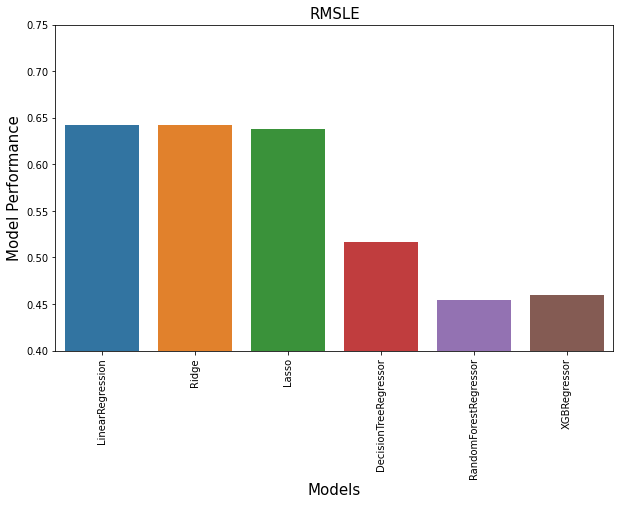

In [193]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.ylim(0.4, 0.75)
plt.title('RMSLE', fontsize=15)
plt.show()

In [207]:
boosting = RandomForestRegressor(n_estimators=10, criterion='mse', max_depth=9, min_samples_split=50,
                           min_samples_leaf=5, random_state=1, n_jobs=-1)

boosting.fit(X_train, y_train)
boosting.fit(X_val, y_val)
final_pred = boosting.predict(X_test)

<BarContainer object of 7 artists>

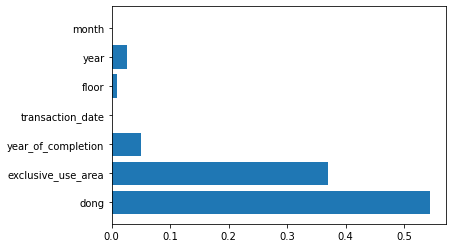

In [208]:
plt.barh(X_train.columns, boosting.feature_importances_)